In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras import models, layers

In [54]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
EPOCHS = 25
CHANNELS = 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("PlantVillage-Tomato",
                                                              image_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                              batch_size = 32,
                                                              shuffle = True)

Found 16011 files belonging to 10 classes.


In [17]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [6]:
len(dataset)

501

In [11]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 4 9 5 4 1 6 0 2 6 8 6 4 7 6 9 4 9 4 6 0 3 3 1 4 6 4 7 0 2 0 9]


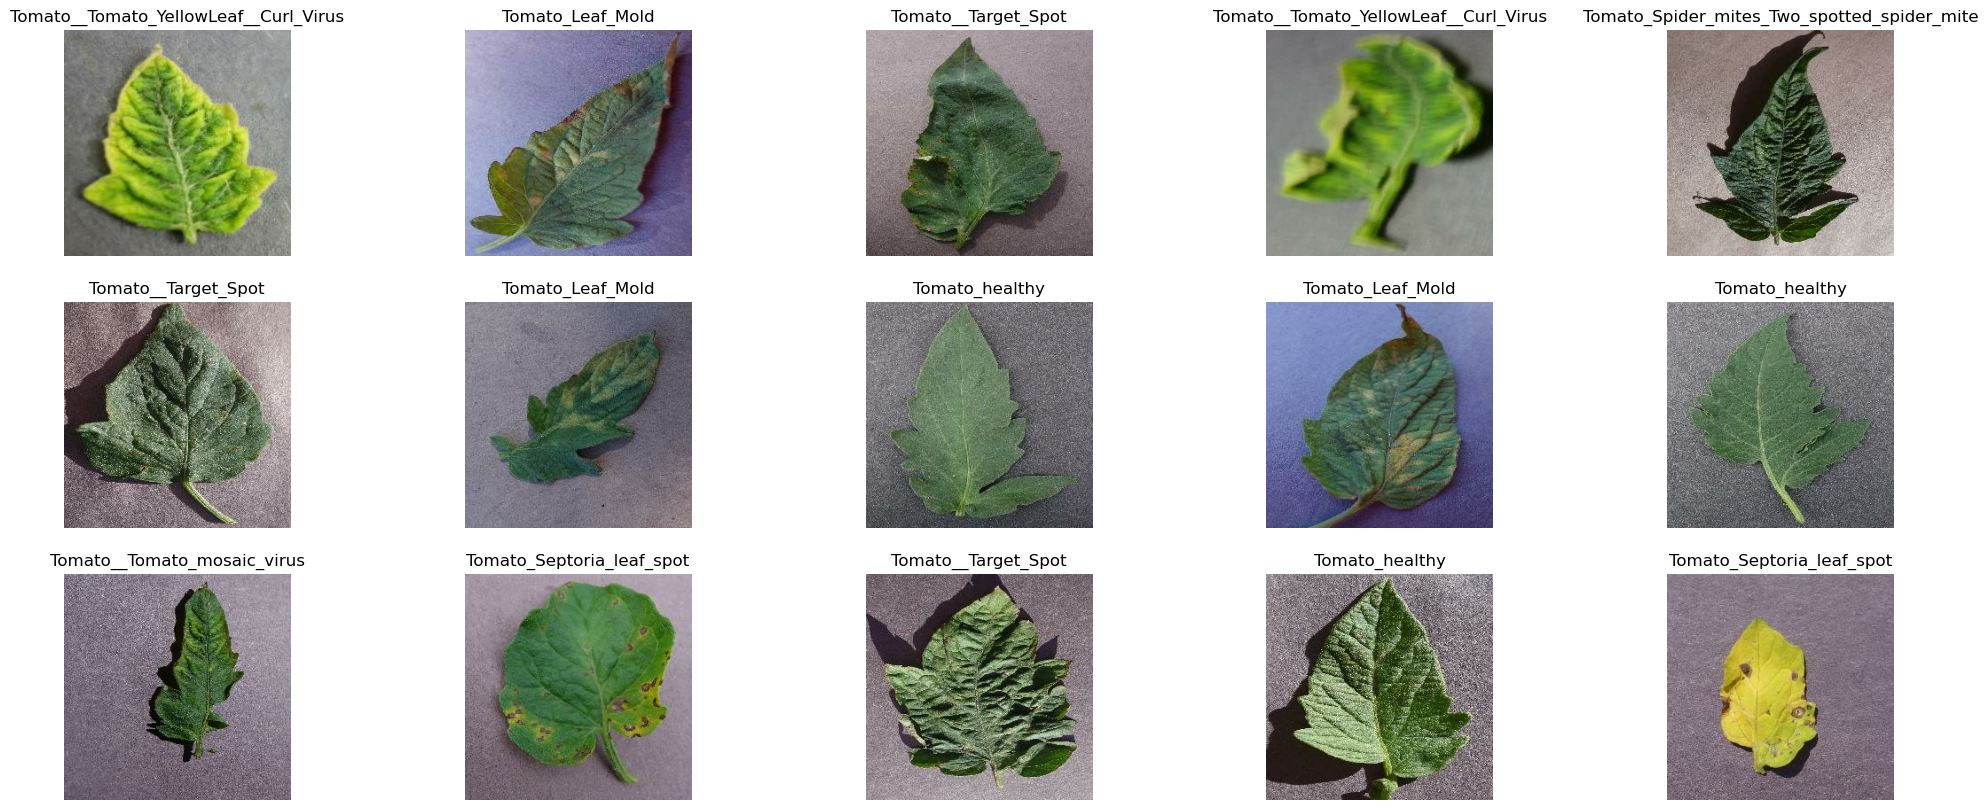

In [27]:
plt.figure(figsize = (25,10))
for image_batch, label_batch in dataset.take(1):
    for i in range (0,15):
        plt.subplot(3,5,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

### Train-Test-Split

In [28]:
len(dataset)

501

In [29]:
TRAIN_SIZE_RATIO = 0.8
VALIDATION_SIZE_RAIO = 0.1
TEST_SIZE_RATIO = 0.1

In [34]:
def get_dataset_partitions_tf(ds, TRAIN_SIZE_RATIO = 0.8, VALIDATION_SIZE_RAIO = 0.1, TEST_SIZE_RATIO = 0.1, shuffle = True, shuffle_size = 10000):
    
    if (shuffle):
        ds.shuffle(shuffle_size, seed = 12)
        
    ds_size = int(len(ds))
    train_size = int(len(ds) * TRAIN_SIZE_RATIO)
    val_size = int(len(ds) * VALIDATION_SIZE_RAIO)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return (train_ds, val_ds, test_ds)

In [36]:
(train_ds, val_ds, test_ds) = get_dataset_partitions_tf(dataset)
(train_ds, val_ds, test_ds)

(<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <SkipDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [37]:
(len(train_ds), len(val_ds), len(test_ds))

(400, 50, 51)

In [38]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

### Pre-Processing

In [39]:
resize_and_rescale = models.Sequential()
resize_and_rescale.add(layers.Resizing(IMAGE_SIZE, IMAGE_SIZE))
resize_and_rescale.add(layers.Rescaling(scale = 1.0/255))

### Data-Augmentation

In [40]:
data_augmentation = models.Sequential()
data_augmentation.add(layers.RandomFlip('horizontal_and_vertical'))
data_augmentation.add(layers.RandomRotation(0.4))

### Model-Building

In [41]:
INPUT_SHAPE = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
N_CLASSES = 10

In [45]:
model = models.Sequential()
# Resize, Re-scale, Augment
model.add(resize_and_rescale)
model.add(data_augmentation)
# Convolution layers
model.add(layers.Conv2D(filters = 48, kernel_size = (3,3), activation = 'relu', input_shape = INPUT_SHAPE))
model.add(layers.MaxPooling2D(pool_size = (2,2)))
model.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size = (2,2)))
model.add(layers.Conv2D(filters = 48, kernel_size = (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size = (2,2)))
model.add(layers.Conv2D(filters = 48, kernel_size = (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size = (2,2)))
model.add(layers.Conv2D(filters = 48, kernel_size = (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size = (2,2)))
model.add(layers.Conv2D(filters = 48, kernel_size = (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size = (2,2)))
# Flatten layer
model.add(layers.Flatten())
# Dense layers
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(N_CLASSES, activation = 'softmax'))

In [46]:
model.build(input_shape = INPUT_SHAPE)

In [47]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 254, 254, 48)      1344      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 48)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      27712     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [49]:
model.compile(optimizer = 'rmsprop',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics = ['accuracy'])

In [55]:
model.fit(train_ds, batch_size = BATCH_SIZE, validation_data = val_ds, verbose = 1, epochs = EPOCHS)

Epoch 1/25
400/400 [==============================] - 727s 2s/step - loss: 1.7336 - accuracy: 0.4058 - val_loss: 1.2998 - val_accuracy: 0.5581
Epoch 2/25
400/400 [==============================] - 708s 2s/step - loss: 1.1714 - accuracy: 0.6012 - val_loss: 1.0177 - val_accuracy: 0.6525
Epoch 3/25
400/400 [==============================] - 714s 2s/step - loss: 0.8690 - accuracy: 0.7023 - val_loss: 0.6170 - val_accuracy: 0.7887
Epoch 4/25
400/400 [==============================] - 625s 2s/step - loss: 0.6876 - accuracy: 0.7626 - val_loss: 0.6154 - val_accuracy: 0.7756
Epoch 5/25
400/400 [==============================] - 610s 2s/step - loss: 0.5853 - accuracy: 0.8001 - val_loss: 0.4576 - val_accuracy: 0.8300
Epoch 6/25
400/400 [==============================] - 603s 2s/step - loss: 0.5081 - accuracy: 0.8263 - val_loss: 0.3657 - val_accuracy: 0.8725
Epoch 7/25
400/400 [==============================] - 579s 1s/step - loss: 0.4410 - accuracy: 0.8463 - val_loss: 0.4631 - val_accuracy: 0.8388

In [56]:
scores = model.evaluate(test_ds)

51/51 [==============================] - 26s 347ms/step - loss: 0.3210 - accuracy: 0.9081


In [57]:
scores

[0.3209723234176636, 0.9081315994262695]

In [58]:
history.history.keys()

NameError: name 'history' is not defined

first image to predict
actual label: Tomato__Tomato_YellowLeaf__Curl_Virus
1/1 [==============================] - 0s 379ms/step
predicted label: Tomato__Tomato_YellowLeaf__Curl_Virus


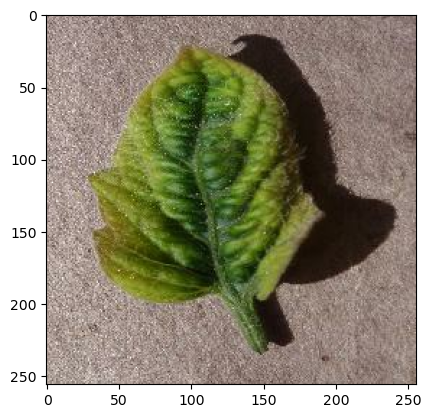

In [75]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [78]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(image_batch[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 35ms/step


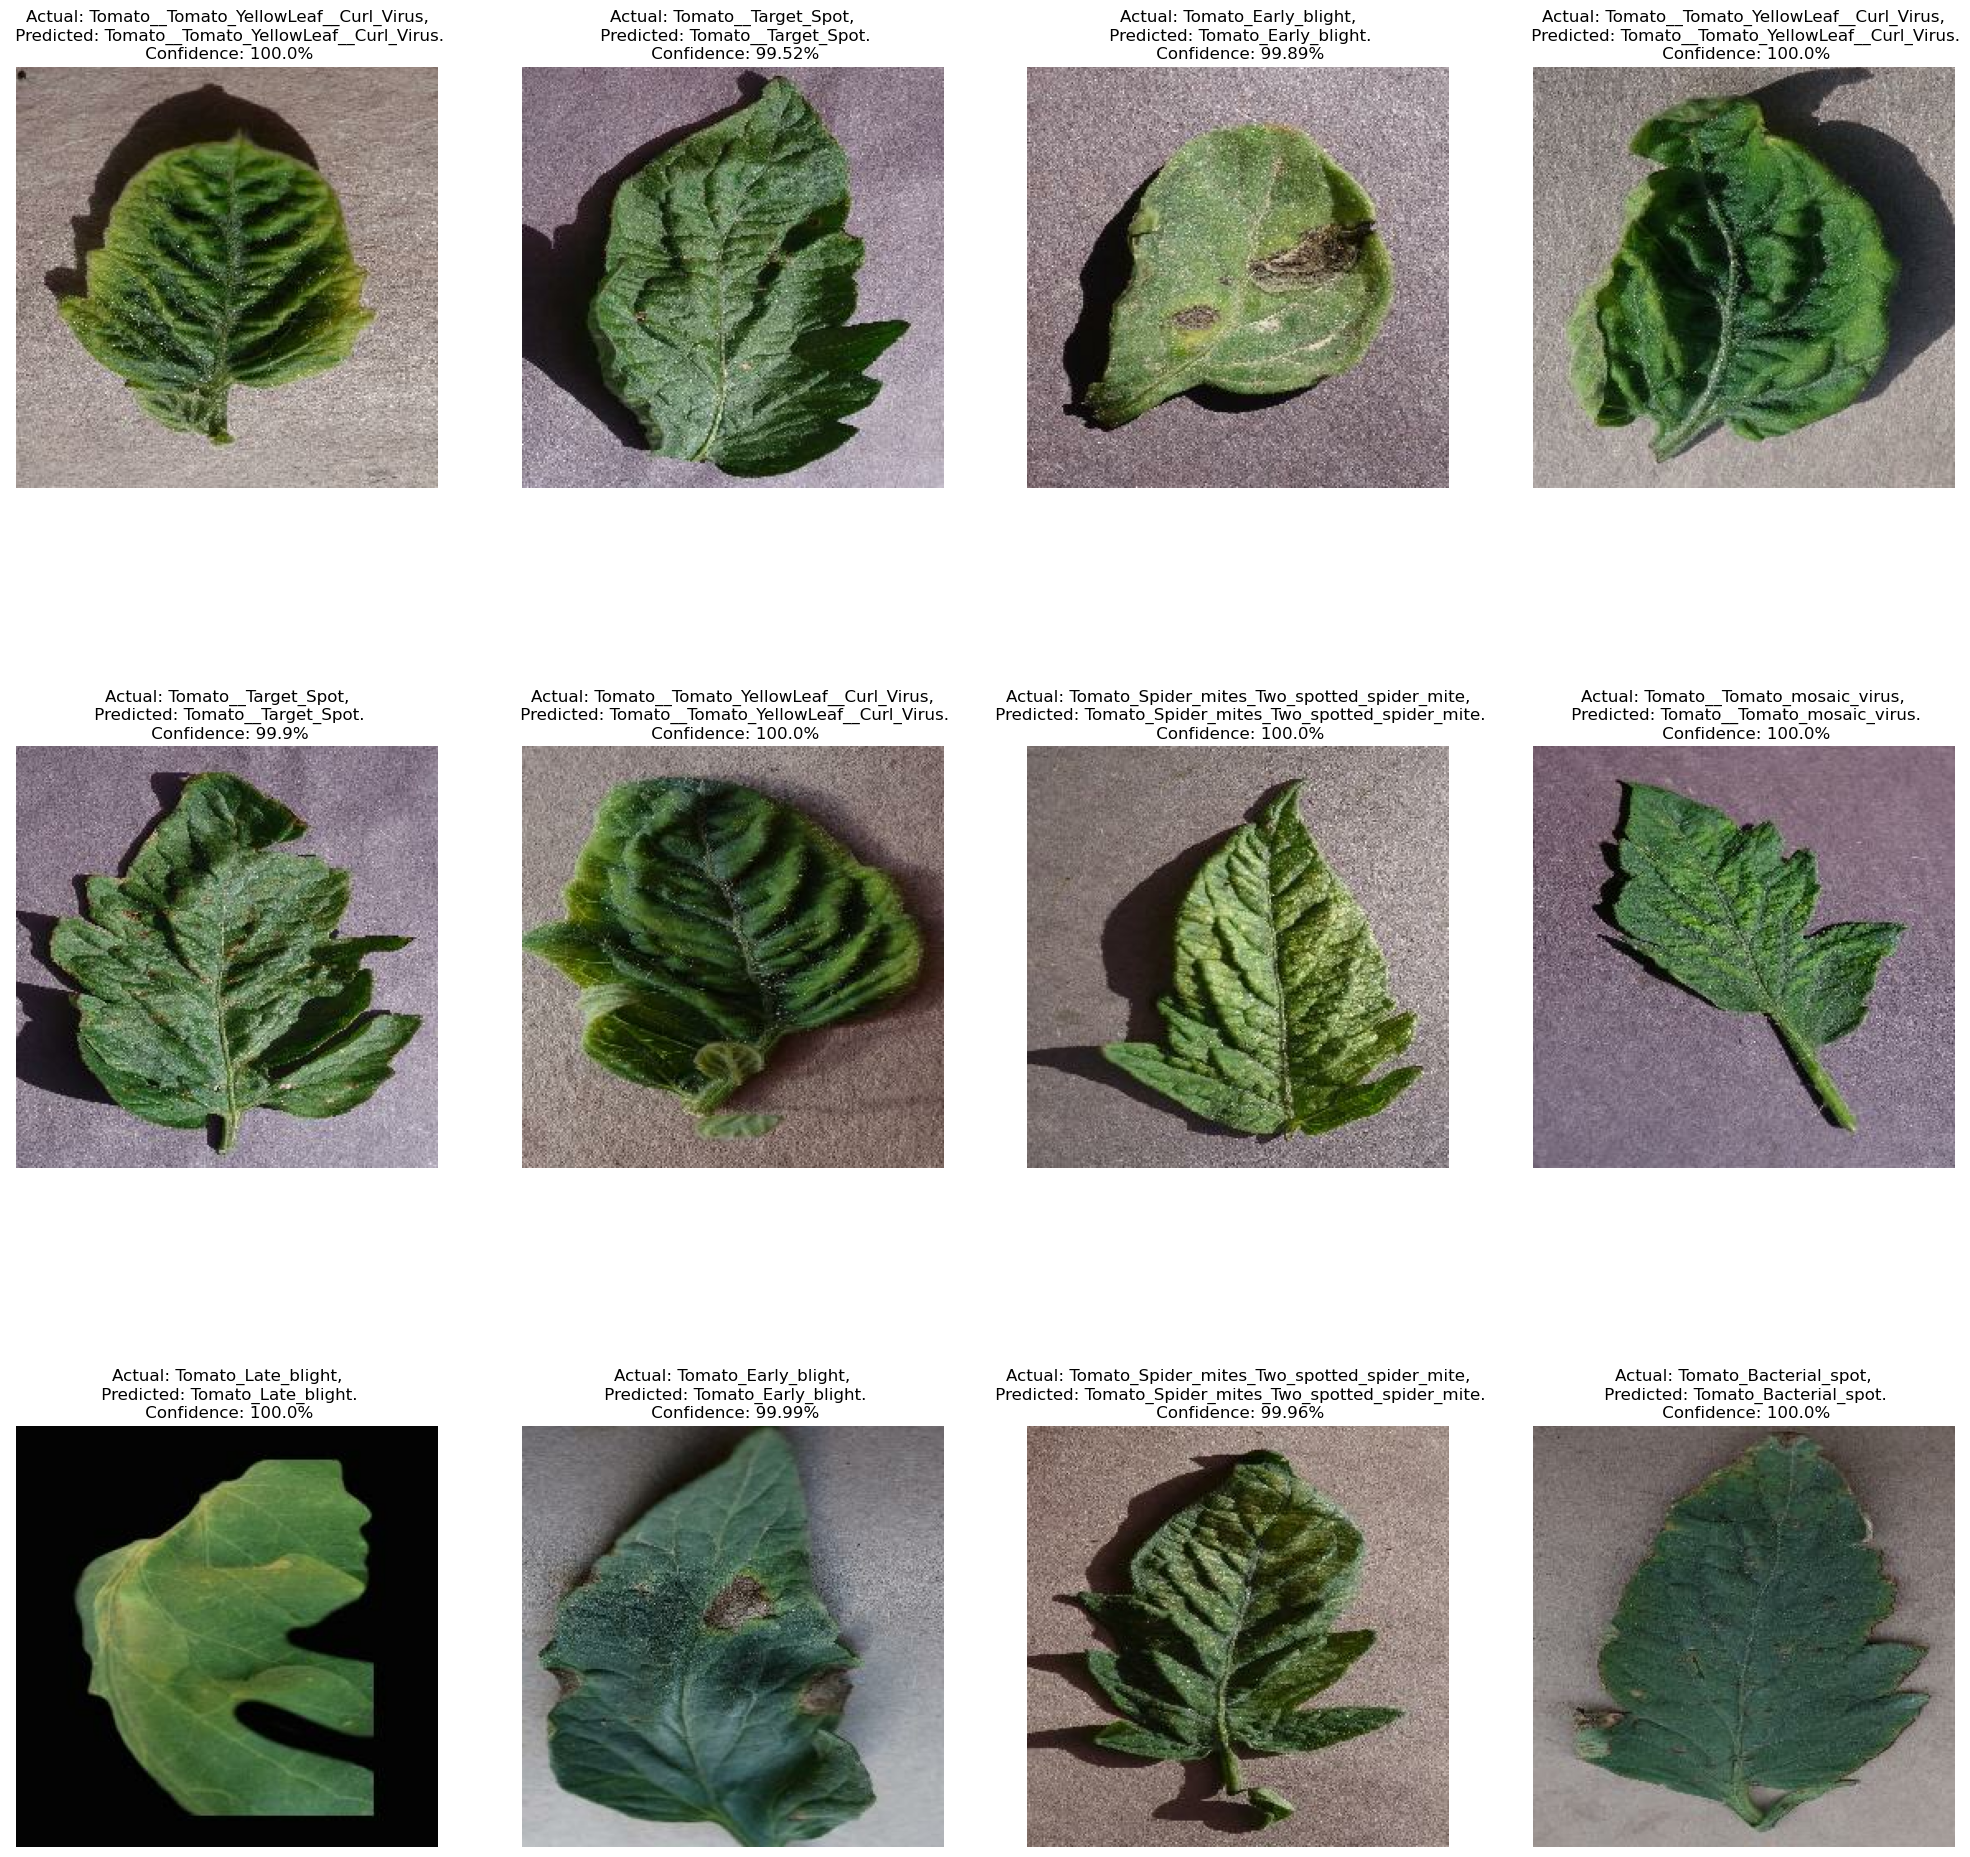

In [82]:
plt.figure(figsize = (25,25))
for image_batch, label_batch in dataset.take(1):
    
    for i in range (0,12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, image_batch[i].numpy())
        actual_class = class_names[label_batch[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis('off')

### Saving the Model

In [83]:
model_version = 1

In [84]:
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [87]:
# for future version saving
import os
model_version = max([int(i) for i in os.listdir("../models")]) + 1
model_version

2